## Import delle librerie

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pickle
import nltk

import seaborn as sns

from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer,f1_score, accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from tensorflow.keras import Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Leggi e filtra dati per categoria

In [2]:
data = pd.read_csv('../data/all_tickets.csv')

In [3]:
data.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48549 entries, 0 to 48548
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             47837 non-null  object
 1   body              48549 non-null  object
 2   ticket_type       48549 non-null  int64 
 3   category          48549 non-null  int64 
 4   sub_category1     48549 non-null  int64 
 5   sub_category2     48549 non-null  int64 
 6   business_service  48549 non-null  int64 
 7   urgency           48549 non-null  int64 
 8   impact            48549 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 3.3+ MB


In [5]:
text_list = data['body'].tolist()

In [6]:
def clean(sentence):
    
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer() 
  
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]  

    stemmed_sentence = [ps.stem(w) for w in filtered_sentence]

    return ' '.join(stemmed_sentence)

In [7]:
text_list = [clean(sentence) for sentence in text_list]

In [8]:
labels_list = data['category'].tolist()

(array([4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 7.2000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.3700e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.4061e+04, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 9.6340e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.6280e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 9.2100e+02, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.3900e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

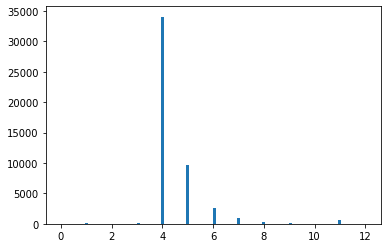

In [9]:
plt.hist(labels_list, bins=100)

In [10]:
n_outputs = len(np.unique(labels_list)) # dimensione dell'output
n_outputs

13

### Funzione per utilizzare anche n_grammi e non solo singoli termini

In [11]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.

    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}

    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.

    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]

    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

## Labels encoding

In [12]:
values = np.array(labels_list)
# integer encode
label_encoder = LabelEncoder()
label_encoder.fit(values)
Y = label_encoder.transform(labels_list)
# binary encode
#onehot_encoder = OneHotEncoder(sparse=False)
#integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
#Y = onehot_encoder.fit_transform(integer_encoded)
print(Y)

[4 6 5 ... 5 4 4]


## Preprocessing del testo

In [13]:
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(text_list)
X = tokenizer.texts_to_sequences(text_list)

In [14]:
# cambiare il parametro max_features a seconda della lunghezza del word_index e rieseguire il fitting del tokenizer
max_features = len(tokenizer.word_index)
max_features

6961

In [15]:
seq_lens = [len(s) for s in X]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 34.3
max length: 859


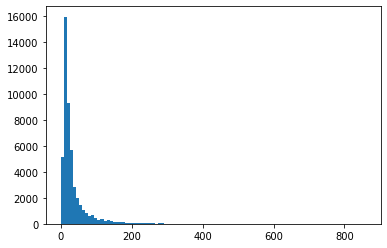

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=100);

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [18]:
ngram_range = 1 # if 2 will add bi-grams features

In [19]:
# se ngram-range è stato inizializzato maggiore di 1 aggiunge gli n_grammi alla sequenza
# se uso gli n_grammi non posso utilizzare gli embedding pre-addestrati
if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in X_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    X_train = add_ngram(X_train, token_indice, ngram_range)
    X_test = add_ngram(X_test, token_indice, ngram_range)
    print('Average train sequence length: {}'.format(
        np.mean(list(map(len, X_train)), dtype=int)))
    print('Average test sequence length: {}'.format(
        np.mean(list(map(len, X_test)), dtype=int)))

In [20]:
maxlen = 300 # lunghezza massima di ogni sequenza testuale

In [21]:
# padding delle sequenze alla stessa lunghezza specificata da maxlen
print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

Pad sequences (samples x time)
x_train shape: (43694, 300)
x_test shape: (4855, 300)


## Caricamento dei glove embeddings preaddestrati

In [22]:
# Set True if you want to use Glove Pretrained embeddings
use_pretrained_embeddings = False
embedding_dim = 100 # dimensione degli embeddings

In [23]:
if use_pretrained_embeddings: 
    # directory con gli embeddings glove preaddestrati
    glove_dir = '../../data/glove-global-vectors-for-word-representation' # This is the folder with the dataset

    print('Loading word vectors')
    embeddings_index = {} # We create a dictionary of word -> embedding
    f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8') # Open file

    # In the dataset, each line represents a new word embedding
    # The line starts with the word and the embedding values follow
    for line in tqdm(f):
        values = line.split()
        word = values[0] # The first value is the word, the rest are the values of the embedding
        embedding = np.asarray(values[1:], dtype='float32') # Load embedding
        embeddings_index[word] = embedding # Add embedding to our embedding dictionary
    f.close()

    print('Found %s word vectors.' % len(embeddings_index))


    # Create a matrix of all embeddings
    all_embs = np.stack(embeddings_index.values())
    emb_mean = all_embs.mean() # Calculate mean
    emb_std = all_embs.std() # Calculate standard deviation
    emb_mean,emb_std

    word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index)) # How many words are there actually

    # Create a random matrix with the same mean and std as the embeddings
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_dim))

    # The vectors need to be in the same position as their index. 
    # Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on

    # Loop over all words in the word index
    for word, i in word_index.items():
        # If we are above the amount of words we want to use we do nothing
        if i >= max_features: 
            continue
        # Get the embedding vector for the word
        embedding_vector = embeddings_index.get(word)
        # If there is an embedding vector, put it in the embedding matrix
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector

## Costruzione e addestramento del modello

In [24]:
batch_size = 32 # batch size per l'addestramento
epochs = 100 # numero di epoche massimo per l'addestramento
filters = 200
kernel_size = 3
hidden_dims = 200

In [25]:
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
if use_pretrained_embeddings: 
    model.add(Embedding(max_features+1,
                        embedding_dim,
                        input_length=maxlen
                        , weights = [embedding_matrix], trainable = True))
    print("using pretrained embeddings")
else:
    model.add(Embedding(max_features+1,
                        embedding_dim,
                        input_length=maxlen))
    print("using embeddings from scratch")
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a softmax:
model.add(Dense(n_outputs))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

history = model.fit(np.array(X_train), np.array(Y_train),
              batch_size=batch_size,
              epochs=epochs,
            validation_split=0.1, callbacks = [callback])

Build model...
using embeddings from scratch
Epoch 1/100
1229/1229 [==============================] - 45s 36ms/step - loss: 0.7846 - accuracy: 0.7769 - val_loss: 0.4834 - val_accuracy: 0.8412
Epoch 2/100
1229/1229 [==============================] - 47s 38ms/step - loss: 0.4483 - accuracy: 0.8545 - val_loss: 0.4709 - val_accuracy: 0.8421
Epoch 3/100
1229/1229 [==============================] - 49s 39ms/step - loss: 0.3665 - accuracy: 0.8771 - val_loss: 0.4593 - val_accuracy: 0.8508
Epoch 4/100
1229/1229 [==============================] - 48s 39ms/step - loss: 0.3025 - accuracy: 0.8976 - val_loss: 0.5036 - val_accuracy: 0.8476
Epoch 5/100
1229/1229 [==============================] - 49s 40ms/step - loss: 0.2553 - accuracy: 0.9132 - val_loss: 0.5060 - val_accuracy: 0.8474
Epoch 6/100
1229/1229 [==============================] - 49s 40ms/step - loss: 0.2162 - accuracy: 0.9273 - val_loss: 0.5580 - val_accuracy: 0.8382
Epoch 7/100
1229/1229 [==============================] - 50s 41ms/step - 

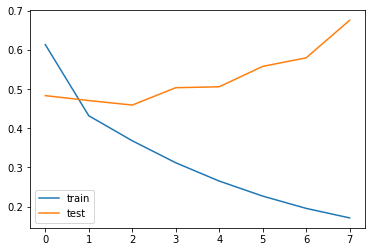

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Valutazione

In [27]:
model.evaluate(X_test, Y_test)

152/152 [==============================] - 1s 8ms/step - loss: 0.7325 - accuracy: 0.8402


[0.7325135469436646, 0.8401647806167603]

In [28]:
predicted = model.predict_classes(X_test, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [30]:
print(accuracy_score(Y_test, predicted))

0.8401647785787848


In [31]:
import itertools

# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

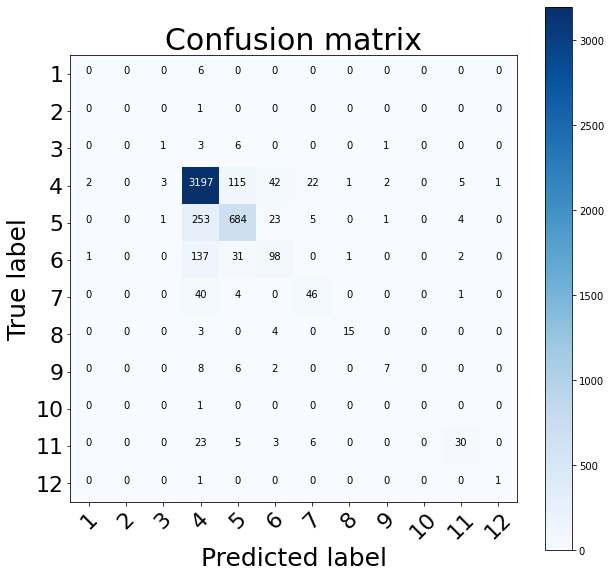

In [32]:
cnf_matrix = confusion_matrix(Y_test, predicted)
fig = plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=np.unique(Y_test), title="Confusion matrix")
plt.show()
fig.savefig('../plots/conv1d_cm.png')
plt.close(fig)

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

In [39]:
report = classification_report(Y_test, predicted, target_names=np.unique(Y_test))

plot = plot_classification_report(report)
fig = plot.get_figure()
fig.savefig("../plots/conv1d_report.png") 

TypeError: object of type 'numpy.int64' has no len()

## Salvataggio del modello, del tokenizer e dell'encoder

In [34]:
# Saving Model Weight
model.save('../models/conv1d/conv1d.h5')

In [35]:
with open('../models/conv1d/conv1d_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
with open('../models/conv1d/conv1d_label_encoder.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)